# Radar absorbing metamaterial

Electromagnetic wave absorbing materials play a crucial role in reducing electromagnetic interference, enhancing stealth capabilities, and improving electromagnetic compatibility across various industries, including electronics, communications, and aerospace. Recent advancements have focused on metamaterials—artificially engineered structures that manipulate electromagnetic waves in ways natural materials cannot, such as achieving a negative refractive index. These materials have gained significant interest due to their potential to enhance the performance of radar detection and stealth technologies.

In this notebook, we will reproduce the results published in the paper of `Zaiqing Yang, Xiaoming Liu, Yuchen Hua, Caiyi Liu, Zhijia Zhang, Zhiyu Ren, Shuang Yuan, and Qiang Wang titled "Broadband radar absorbing metamaterial based on Al @SiO2 conductive composite film", (2024).` [DOI: https://doi.org/10.1364/OE.510163](https://opg.optica.org/oe/fulltext.cfm?uri=oe-32-4-5206&id=546136), where the authors design a Al@SiO2 composite conductive film metamaterial to achieve wideband absorption in the frequency range of 10.6 GHz to 26.0 GHz. 

The composite film sits over a PMMA substrate, and a thin layer of metal is deposited on the bottom layer of the substrate. The composite film and the metal layer are modeled with Tidy3D`s [Medium2D](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Medium2D.html) class. Since the metasurface is symmetric, we will model only a unit cell and use [periodic boundary conditions](https://docs.flexcompute.com/projects/tidy3d/en/v2.7.6/faq/docs/faq/how-do-i-set-the-periodic-boundary-condition.html).


<img src="img/RadarAbsorberMetasurface.png" width="600" alt="Schematic of the experiment">

Through this example, we demonstrate some features of Tidy3D, such as assembling 2D materials, using PEC mediums, periodic boundary conditions, and rotating and translating structures.

For more metamaterial and other examples, please refer to our [example library](https://www.flexcompute.com/tidy3d/learning-center/example-library/), where we showcase examples such as [Graphene metamaterial absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/GrapheneMetamaterial/) and [Dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/).

In [1]:
import numpy as np
import tidy3d as td
import tidy3d.web as web
import pandas as pd
import matplotlib.pyplot as plt

## Simulation Setup

First, we will define the simulation parameters.

It is worth to mention that the units in Tidy3D are microns and seconds. Hence, frequency units are Hertz, wavelength and all geometry definitions are in microns.

In [2]:
# geometry parameters as defined in the paper

p = 12e3    # lattice constant (um)
a = 1e3     # windmill width (um)
b = 4e3     # windmill arms length (um)
c = 1.9e3   # half of hexagon size (um)
d = 3.8e3   # hexagon size (um)
g = 2e3     # windmill gap (um)
h1 = 0.2    # composite material thickness (um)
h2 = 2.6e3  # PMMA thickness (um)
h3 = 0.05e3 # metal layer thickness (um)

# operating frequency (Hz)
freq1 = 5e9
freq2 = 30e9
fwidth = (freq2 - freq1) / 2
freq0 = freq1 + fwidth

freqs = np.linspace(freq1, freq2, 1001)

centralWl = td.C_0 / freq0

# simulation size
size = (p, p, h2 + 2 * centralWl)


source_center = h2 + centralWl / 3
monitor_center = source_center + centralWl / 3

Next, we define our material properties. The composite material will be modeled by its resistivity, as reported in the paper.

The composite material and the thin metal layer will be modeled as [2D mediums](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/how-can-i-define-a-2d-material.html). This definition is convenient for GHz simulations since it captures the physics of a thin layer without the need of a mesh region with a grid much smaller than the operating wavelength.

The composite layer is modeled by its square resistance, reported in the paper as $60\ \Omega/\text{sq}$. To be used in Tidy3D's [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Structure.html) object, it is converted to conductivity. The metal layer is modeled as a [Perfect Electric Conductor (PEC) material](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PECMedium.html).

In [3]:
# material properties
resistivity = 60 * h1 # (Ohms um)
pmma_index = 1.51

# modeling the Al@SiO2 as a 2D medium
AlSiO2 = td.Medium2D.from_medium(td.Medium(conductivity=1 / resistivity), thickness=h1)

# modeling the metal plate as a 2D medium with conductivity near infinity
metal = td.Medium2D.from_medium(td.PECMedium(), thickness=h3)

# PMMA medium
pmma = td.Medium(permittivity=pmma_index**2)

### Defining the Geometry

We will simulate three different unit cells: one formed by the hexagon alone, one by the windmill alone, and one complete unit combining the hexagon and the windmill.

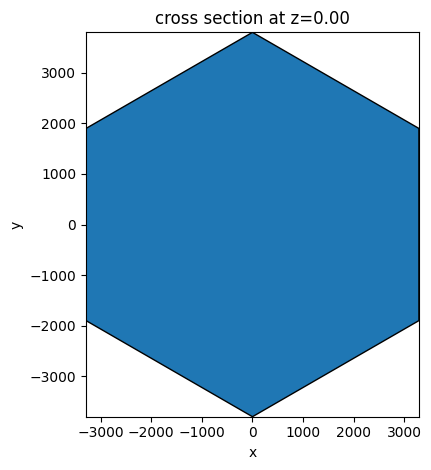

In [4]:
# function to define the hexagon 2D structure
def get_hexagon():
    xSize = c * np.sqrt(3)

    vertices = [[-xSize, c], [0, d], [xSize, c], [xSize, -c], [0, -d], [-xSize, -c]]

    return td.PolySlab(vertices=vertices, slab_bounds=(0, 0))


ax = get_hexagon().plot(z=0)
plt.show()

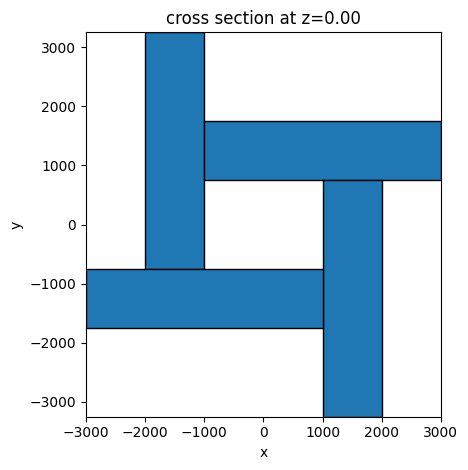

In [5]:
# function to define the windmill 2D structure
def get_windmill():
    t1 = td.Box(size=(a, b, 0), center=(0, 0, 0)) + td.Box(
        size=(b, a, 0), center=(b / 2 + a / 2, 0, 0)
    )

    t1 += t1.rotated(angle=np.pi, axis=2).translated(g + a, -b / 2 - a / 2, 0)

    return t1.translated(-g / 2 - a / 2, (b - a) / 4 + a / 2, 0)


get_windmill().plot(z=0)
plt.show()

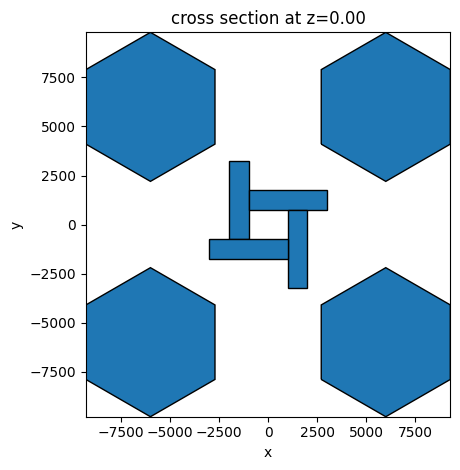

In [6]:
# defining the whole structure
def get_structure():
    geo = get_windmill()
    hex = get_hexagon()
    for i in [p / 2, -p / 2]:
        for j in [-p / 2, p / 2]:
            geo += hex.translated(i, j, 0)
    return geo


get_structure().plot(z=0)
plt.show()

Next, we define the plane wave source and the monitors for calculating flux and visualizing fields.

In [7]:
# defining source and monitors
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)

# Sources
source = td.PlaneWave(
    source_time=source_time,
    center=[0, 0, source_center],
    size=(td.inf, td.inf, 0),
    direction="-",
)


# monitor for reflected field
reflection_field_monitor = td.FieldMonitor(
    center=(0, 0, monitor_center),
    size=(td.inf, td.inf, 0),
    name="reflection_field_monitor",
    freqs=[freq0],
)

# monitor for the fields at the structure
field_monitor = td.FieldMonitor(
    center=(0, 0, h2 / 2), size=(td.inf, td.inf, 0), name="field_monitor", freqs=[freq0]
)

# monitor to calculate Flux
reflection_monitor = td.FluxMonitor(
    center=reflection_field_monitor.center, size=reflection_field_monitor.size, name="reflection_monitor", freqs=freqs
)


# grid specification. Define a high value for min_steps_per_wvl
# due to the dimensions are small comparing with the target wavelength
grid_spec = td.GridSpec.auto(min_steps_per_wvl=100)

As we are simulating a single unit cell at normal incidence, the boundary conditions are defined as [Periodic](https://docs.flexcompute.com/projects/tidy3d/en/pre-2.8/faq/docs/faq/how-do-i-set-the-periodic-boundary-condition.html). If an angled source is needed, the boundary conditions must be changed to [Bloch periodic](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/what-is-the-difference-between-periodic-and-bloch-boundaries.html).

In [8]:
# defining boundary conditions
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary.pml(),
)

In [9]:
# defining the structures

substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-1e12, -1e12, -h2 / 2), rmax=(1e12, 1e12, h2 / 2)
    ),
    medium=pmma,
)

film = td.Structure(geometry=get_structure().translated(0, 0, h2 / 2), medium=AlSiO2)

windmill = td.Structure(geometry=get_windmill().translated(0, 0, h2 / 2), medium=AlSiO2)

hexagon = td.Structure(geometry=get_hexagon().translated(0, 0, h2 / 2), medium=AlSiO2)

reflective_metal = td.Structure(
    geometry=td.Box(center=(0, 0, 0 - h2 / 2), size=(td.inf, td.inf, 0)), medium=metal
)

Now, we create a simulation object for each configuration: the windmill, the hexagon, and the complete unit cell.

In [10]:
# simulation object
sim_base = td.Simulation(
    size=size,
    center=(0, 0, 0),
    grid_spec=grid_spec,
    structures=[],
    sources=[source],
    monitors=[reflection_field_monitor, field_monitor, reflection_monitor],
    run_time=10000e-12,
    boundary_spec=boundary_spec,
    symmetry=[0, 0, 0],
)

sim1 = sim_base.updated_copy(structures=[substrate, hexagon, reflective_metal])
sim2 = sim_base.updated_copy(structures=[substrate, windmill, reflective_metal])
sim3 = sim_base.updated_copy(structures=[substrate, film, reflective_metal])

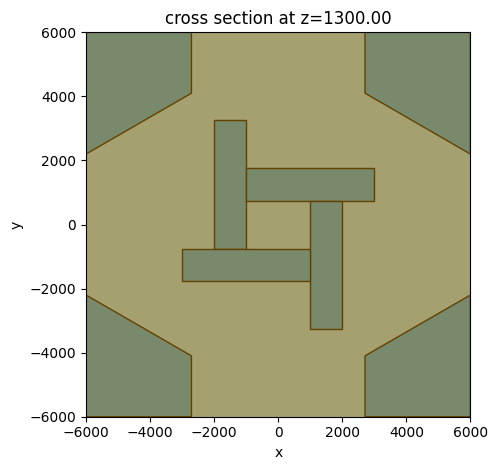

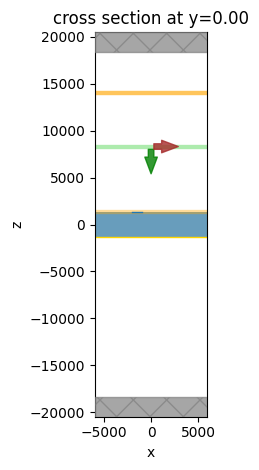

In [11]:
# checking simulation
sim3.plot(z=h2 / 2)
sim3.plot(y=0)

plt.show()

We then create and run a batch simulation for the three structures.

In [12]:
simulations = {"hexagon": sim1, "windmill": sim2, "film": sim3}

batch = web.Batch(simulations=simulations, verbose=True)
results = batch.run(path_dir="batch_simulations")

Output()

19:12:17 -03 Started working on Batch containing 3 tasks.

19:12:21 -03 Maximum FlexCredit cost: 0.200 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

19:13:29 -03 Batch complete.

Output()

To plot the absorption, we can exploit the Plane Wave source [normalization](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/How-are-results-normalized.html), which injects 1 Watt at every frequency. Hence, absorption is calculated as (1 - reflected light). As we can see, there is good agreement with the results reported in Fig. 1 of the paper.

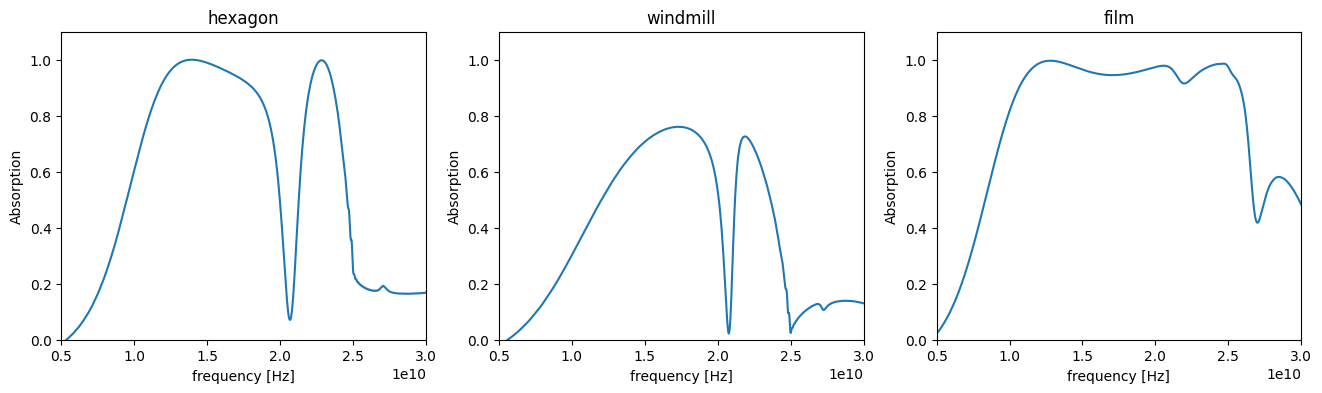

In [13]:
fig, Ax = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(Ax):
    sim = list(simulations.keys())[i]
    sim_data = results[sim]
    absorption = 1 - sim_data["reflection_monitor"].flux
    absorption.plot(ax=ax)
    ax.set_title(sim)
    ax.set_ylabel("Absorption")
    ax.set_ylim(0, 1.1)
    ax.set_xlim(5e9, 30e9)

plt.show()

We can also visualize the metasurface and the reflected fields.

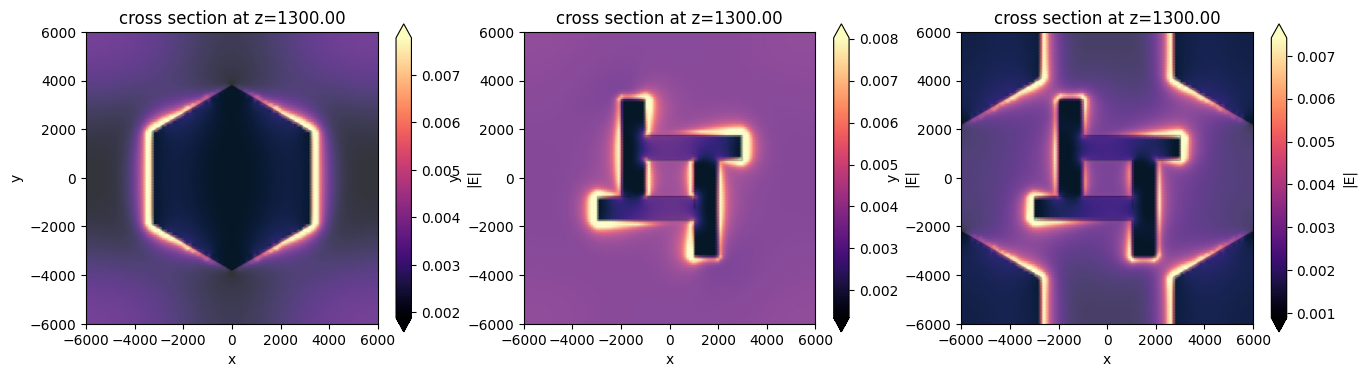

In [14]:
# fields at the metasurface plane
fig, Ax = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(Ax):

    sim = list(simulations.keys())[i]
    sim_data = results[sim]
    sim_data.plot_field('field_monitor','E','abs',ax=ax,shading='gouraud')

plt.show()

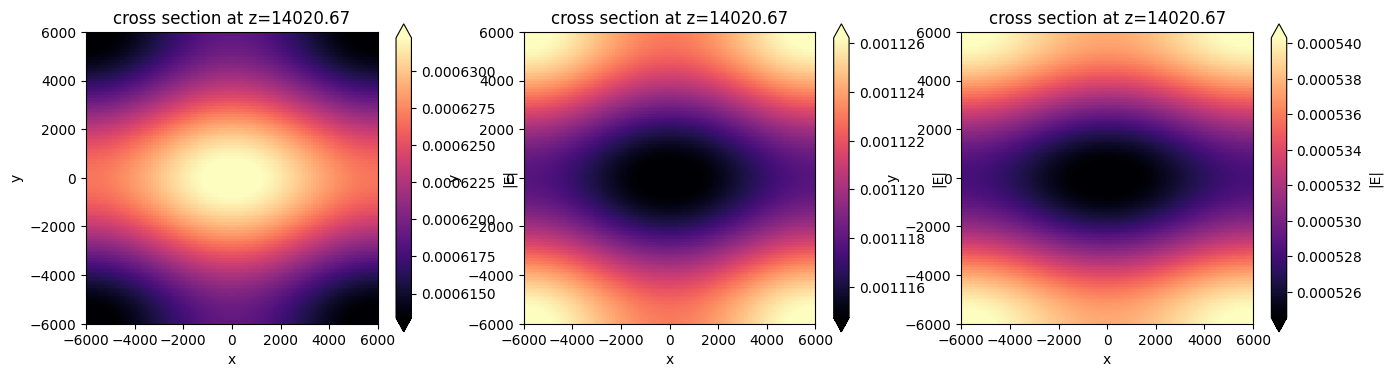

In [15]:
# reflected fields
fig, Ax = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(Ax):

    sim = list(simulations.keys())[i]
    sim_data = results[sim]
    sim_data.plot_field('reflection_field_monitor','E','abs',ax=ax)

plt.show()